KERAS: Callbacks & Model improvement

#Connect to Python 3.10 - Pytorch and Tensorflow kernel

In [ ]:
import os
# Force TensorFlow to use CPU only (avoids GPU memory errors)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

In [33]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [3]:
# We won't save the weights and models for this notebook because
# generating them with different options is the whole point of 
# these demonstrations.

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False


import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.models import load_model

class File_Helper:

	"""
	These routines let us conveniently save and load input data, such
	as text and image files, as well as save and load Keras model files
	and weight files.  When we save a file, the corresponding directory 
	is created if necessary. 
	
	When we make the object, we can optionally set the one argument really_save_files
	to True or False, depending on whether or not we want save_xx() calls to really
	write files. It's time-saving to set this to False when debugging because writing
	files can take a while. The default value is True.
	
	Here's a typical way to import this package from a file in a folder two levels down
	(adapted from https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
	
	# find the absolute path to the parent folder and add that to Python's search list
	import os, sys, inspect
	current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
	sys.path.insert(0, os.path.dirname(current_dir)) # path to grandparent dir
	# Now that we can find the folder, import the package and instantiate a File_Helper object
	from Python_Utilities import File_Helper
	file_helper = File_Helper(True)  
	"""
	
	def __init__(self, really_save_files=True):
		self.really_save_files = really_save_files
		self.saved_output_dir = 'saved_output'
		self.input_data_dir = 'input_data'
		self.saved_models_dir = 'saved_models'
		self.saved_weights_dir = 'saved_weights'

	def get_input_file_path(self, filename):
		"""Get the local path relative to the calling file's location to the input file"""
		return self.input_data_dir + '/' + filename
	
	def check_for_directory(self, directory, create_if_needed=True):
		"""See if the directory exists. Optionally, create it."""
		path_exists = os.path.exists(directory)
		if path_exists:
			if not os.path.isdir(directory):
				raise Exception('Found '+directory+' but it is a file, not a directory')
				return False
			return True
		if create_if_needed:
			os.makedirs(directory)
		return path_exists

	def save_figure(self, filename):
		"""Save the figure. Call this just before plt.show()."""
		if self.really_save_files and (filename != None):
			self.check_for_directory(self.saved_output_dir)
			plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

	def load_model_weights(self, model, weights_filename):
		"""If the weights file exists, load from it and return True, else return False."""
		fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model.load_weights(fullpath)
				return True
		return False

	def save_model_weights(self, model, weights_filename):
		"""Save the weights file in the saved weights directory."""
		if self.really_save_files and (weights_filename != None):
			self.check_for_directory(self.saved_weights_dir)
			fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
			model.save_weights(fullpath)

	def load_model(self, model_filename):
		"""If the model file exists, load from it and return the model, else return None."""
		fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model = load_model(fullpath)
				return model
		return None

	def save_model(self, model, model_filename):
		"""Save the model file in the saved models directory."""
		if self.really_save_files and (model_filename != None):
			self.check_for_directory(self.saved_models_dir)
			fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
			model.save(fullpath)

	def get_saved_output_dir(self):
		"""Get the name of the directory where we save matplotlib output PNG files."""
		return self.saved_output_dir
	
	def get_input_data_dir(self):
		"""Get the name of the directory where we look for input files."""
		return self.input_data_dir
	
	def get_saved_weights_dir(self):
		"""Get the name of the directory where we read and write Keras weight files."""
		return self.saved_weights_dir
	
	def get_saved_models_dir(self):
		"""Get the name of the directory where we read and write Keras model files."""
		return self.saved_models_dir
	
file_helper = File_Helper(save_files)

In [4]:
# Build our 2-layer MNIST model to demonstrate callbacks

random_seed = 42

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test 
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, activation='softmax'))
    return model

def make_compiled_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

In [6]:
# make the model
model = make_compiled_model()

# seed the random number generator
np.random.seed(random_seed)

# Make a checkpoint routine to save val_loss every 5th epoch

checkpoint_folder_name = 'NB08-checkpointed-models'
file_helper.check_for_directory(checkpoint_folder_name)
filename = checkpoint_folder_name+'/model-epoch-{epoch:03d}-val_loss-{val_loss:0.3f}.keras'
checkpointer = ModelCheckpoint(filename, monitor='accuracy', save_freq='epoch') 

# call fit() to train the model, and save the history
history = model.fit(X_train, y_train,
                    validation_split=0.25, epochs=20, batch_size=256, verbose=2,
                    callbacks = [checkpointer] )

Epoch 1/20
176/176 - 2s - 12ms/step - accuracy: 0.9041 - loss: 0.3419 - val_accuracy: 0.9481 - val_loss: 0.1892
Epoch 2/20
176/176 - 1s - 8ms/step - accuracy: 0.9583 - loss: 0.1421 - val_accuracy: 0.9609 - val_loss: 0.1323
Epoch 3/20
176/176 - 1s - 8ms/step - accuracy: 0.9739 - loss: 0.0932 - val_accuracy: 0.9687 - val_loss: 0.1040
Epoch 4/20
176/176 - 1s - 8ms/step - accuracy: 0.9811 - loss: 0.0671 - val_accuracy: 0.9705 - val_loss: 0.0989
Epoch 5/20
176/176 - 1s - 8ms/step - accuracy: 0.9866 - loss: 0.0496 - val_accuracy: 0.9724 - val_loss: 0.0906
Epoch 6/20
176/176 - 1s - 8ms/step - accuracy: 0.9907 - loss: 0.0380 - val_accuracy: 0.9741 - val_loss: 0.0872
Epoch 7/20
176/176 - 2s - 10ms/step - accuracy: 0.9932 - loss: 0.0279 - val_accuracy: 0.9735 - val_loss: 0.0858
Epoch 8/20
176/176 - 2s - 9ms/step - accuracy: 0.9950 - loss: 0.0223 - val_accuracy: 0.9753 - val_loss: 0.0843
Epoch 9/20
176/176 - 2s - 9ms/step - accuracy: 0.9966 - loss: 0.0164 - val_accuracy: 0.9753 - val_loss: 0.0795

In [10]:
# make the model
model = make_compiled_model()

# Make a checkpoint routine to save val_loss every 5th epoch
filename = checkpoint_folder_name+'/model-weights-epoch-{epoch:03d}-acc-{accuracy:0.3f}.weights.h5'
checkpointer = ModelCheckpoint(filename, monitor='accuracy', save_weights_only=True, save_freq='epoch') 

# call fit() to train the model, and save the history
history = model.fit(X_train, y_train,
                    validation_split=0.25, epochs=25, batch_size=256, verbose=2,
                    callbacks = [checkpointer] )

Epoch 1/25
176/176 - 2s - 13ms/step - accuracy: 0.9029 - loss: 0.3455 - val_accuracy: 0.9473 - val_loss: 0.1834
Epoch 2/25
176/176 - 1s - 8ms/step - accuracy: 0.9586 - loss: 0.1432 - val_accuracy: 0.9629 - val_loss: 0.1292
Epoch 3/25
176/176 - 2s - 9ms/step - accuracy: 0.9741 - loss: 0.0925 - val_accuracy: 0.9671 - val_loss: 0.1096
Epoch 4/25
176/176 - 2s - 9ms/step - accuracy: 0.9817 - loss: 0.0666 - val_accuracy: 0.9716 - val_loss: 0.0969
Epoch 5/25
176/176 - 1s - 8ms/step - accuracy: 0.9861 - loss: 0.0510 - val_accuracy: 0.9730 - val_loss: 0.0891
Epoch 6/25
176/176 - 1s - 8ms/step - accuracy: 0.9904 - loss: 0.0374 - val_accuracy: 0.9743 - val_loss: 0.0853
Epoch 7/25
176/176 - 1s - 8ms/step - accuracy: 0.9928 - loss: 0.0283 - val_accuracy: 0.9766 - val_loss: 0.0859
Epoch 8/25
176/176 - 1s - 8ms/step - accuracy: 0.9951 - loss: 0.0219 - val_accuracy: 0.9779 - val_loss: 0.0779
Epoch 9/25
176/176 - 2s - 9ms/step - accuracy: 0.9969 - loss: 0.0160 - val_accuracy: 0.9765 - val_loss: 0.0797


In [12]:
# modify the learning rate over time with a callback
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

# make the model but don't compile it
model = make_model()

sgd = SGD(learning_rate=0.0, momentum=0.9, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

def simpleSchedule(epoch_number):
    return max(.1, 1-(0.01*epoch_number)) # start at 1 & drop to 0.1

lr_scheduler = LearningRateScheduler(simpleSchedule)

history = model.fit(X_train, y_train, validation_split=0.25, 
                    epochs=25, batch_size=256, verbose=2,
                    callbacks=[lr_scheduler])

Epoch 1/25
176/176 - 2s - 9ms/step - accuracy: 0.8912 - loss: 0.0703 - val_accuracy: 0.9483 - val_loss: 0.0352 - learning_rate: 1.0000
Epoch 2/25
176/176 - 1s - 6ms/step - accuracy: 0.9615 - loss: 0.0270 - val_accuracy: 0.9639 - val_loss: 0.0251 - learning_rate: 0.9900
Epoch 3/25
176/176 - 1s - 6ms/step - accuracy: 0.9742 - loss: 0.0195 - val_accuracy: 0.9686 - val_loss: 0.0216 - learning_rate: 0.9800
Epoch 4/25
176/176 - 1s - 6ms/step - accuracy: 0.9801 - loss: 0.0157 - val_accuracy: 0.9730 - val_loss: 0.0195 - learning_rate: 0.9700
Epoch 5/25
176/176 - 1s - 6ms/step - accuracy: 0.9837 - loss: 0.0128 - val_accuracy: 0.9737 - val_loss: 0.0186 - learning_rate: 0.9600
Epoch 6/25
176/176 - 1s - 6ms/step - accuracy: 0.9875 - loss: 0.0106 - val_accuracy: 0.9759 - val_loss: 0.0173 - learning_rate: 0.9500
Epoch 7/25
176/176 - 1s - 6ms/step - accuracy: 0.9903 - loss: 0.0090 - val_accuracy: 0.9769 - val_loss: 0.0167 - learning_rate: 0.9400
Epoch 8/25
176/176 - 1s - 6ms/step - accuracy: 0.9923 -

In [13]:
# stop when the validation loss starts going back up
from tensorflow.keras.callbacks import EarlyStopping

# make the model
model = make_compiled_model()

early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(X_train, y_train, validation_split=0.25, 
                    epochs=100, batch_size=256, verbose=2,
                    callbacks=[early_stopper])

Epoch 1/100
176/176 - 2s - 11ms/step - accuracy: 0.9050 - loss: 0.3428 - val_accuracy: 0.9482 - val_loss: 0.1824
Epoch 2/100
176/176 - 1s - 7ms/step - accuracy: 0.9589 - loss: 0.1423 - val_accuracy: 0.9625 - val_loss: 0.1306
Epoch 3/100
176/176 - 1s - 7ms/step - accuracy: 0.9727 - loss: 0.0935 - val_accuracy: 0.9677 - val_loss: 0.1119
Epoch 4/100
176/176 - 1s - 7ms/step - accuracy: 0.9817 - loss: 0.0662 - val_accuracy: 0.9674 - val_loss: 0.1051
Epoch 5/100
176/176 - 1s - 7ms/step - accuracy: 0.9859 - loss: 0.0496 - val_accuracy: 0.9733 - val_loss: 0.0889
Epoch 6/100
176/176 - 1s - 7ms/step - accuracy: 0.9898 - loss: 0.0376 - val_accuracy: 0.9746 - val_loss: 0.0827
Epoch 7/100
176/176 - 1s - 7ms/step - accuracy: 0.9932 - loss: 0.0283 - val_accuracy: 0.9756 - val_loss: 0.0805
Epoch 8/100
176/176 - 1s - 7ms/step - accuracy: 0.9947 - loss: 0.0225 - val_accuracy: 0.9773 - val_loss: 0.0773
Epoch 9/100
176/176 - 1s - 7ms/step - accuracy: 0.9967 - loss: 0.0164 - val_accuracy: 0.9766 - val_loss

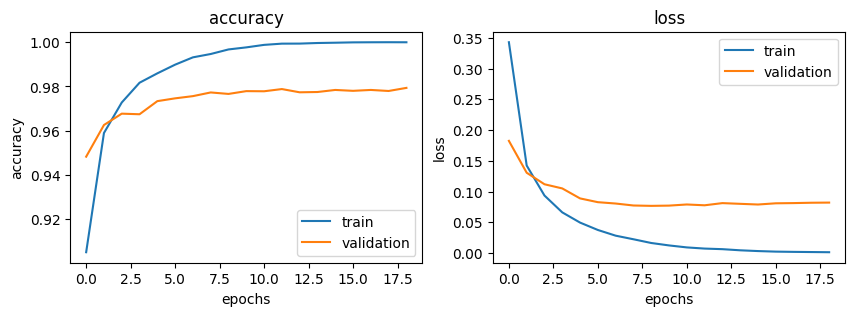

In [14]:
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')

file_helper.save_figure('early-stopping-demo')
plt.show()

In [34]:
import tensorflow as tf
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():
    # create an empty model
    model = Sequential()
    # add a fully-connected hidden layer with #nodes = #pixels
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    # add an output layer with softmax activation
    model.add(Dense(number_of_classes, activation='softmax'))
    # compile the model to turn it from specification to code
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

def make_two_hidden_layers_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_pixels, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def make_hidden_layer_n_neurons(num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# make a general model of any number of dense layers, each optionally followed by dropout
def make_layers_model(neurons_per_layer, dropout_per_layer, learning_rate=0.001):
    model = Sequential()
    for i in range(len(neurons_per_layer)):
        kwargs = { 'kernel_initializer': 'normal', 'activation': 'relu' }
        if i==0:
            kwargs['input_dim'] = number_of_pixels
        if dropout_per_layer[i]:
            kwargs['kernel_constraint'] = tf.keras.constraints.MaxNorm(3)
        model.add(Dense(neurons_per_layer[i], **kwargs))
        if dropout_per_layer[i]:
            model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [17]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [20]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism as a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=25, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    models_folder_name = 'NB09-checkpointed-models'
    file_helper.check_for_directory(models_folder_name)

    filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.keras'
    model.save(filename)
    return history

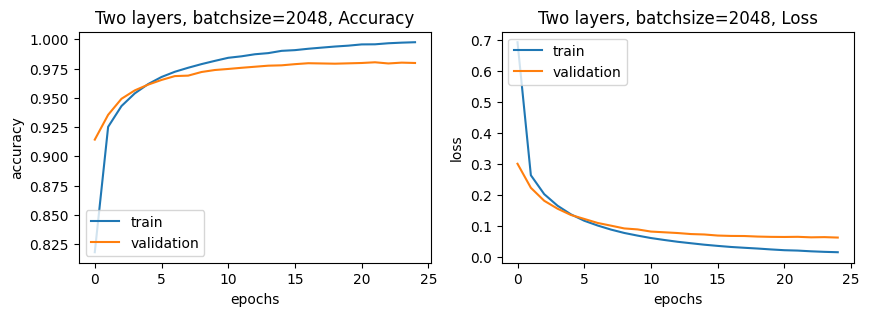

batchsize  2048  elapsed time= 21.269569396972656


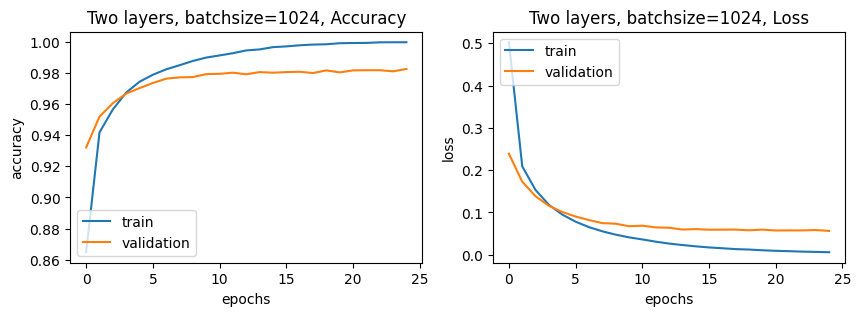

batchsize  1024  elapsed time= 23.9923255443573


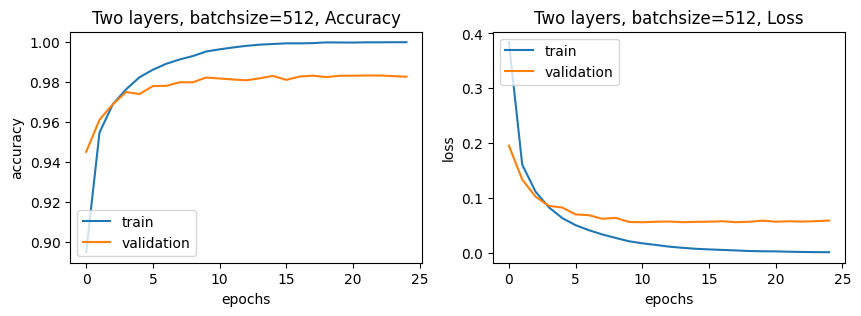

batchsize  512  elapsed time= 29.221357345581055


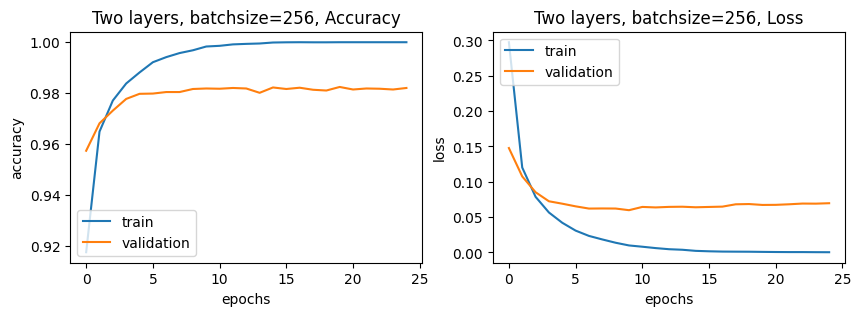

batchsize  256  elapsed time= 40.58344006538391


In [21]:
#
# WARNING: If you're training on a CPU (that is, without a GPU),
# then as batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
# I'm using big batches here so the notebook runs in less than a
# few days. If you have a fast machine and/or a great GPU, it would
# be instructive to include more sizes, as in the commented definition
# of batch_sizes.
#
import time
history_list = []
time_list = []

#batch_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16, 8]
batch_sizes = [2048, 1024, 512, 256]
for batchsize in batch_sizes:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

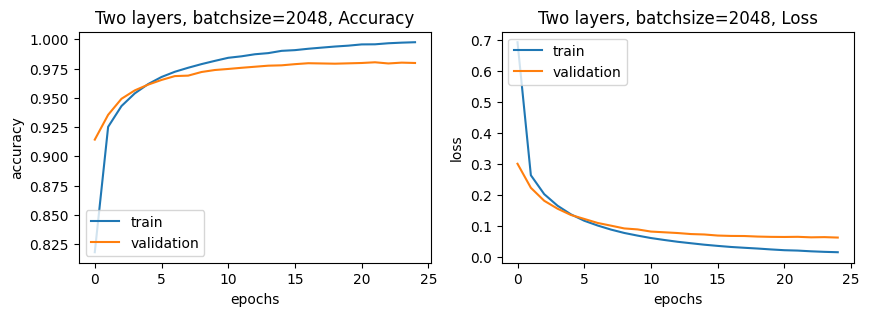

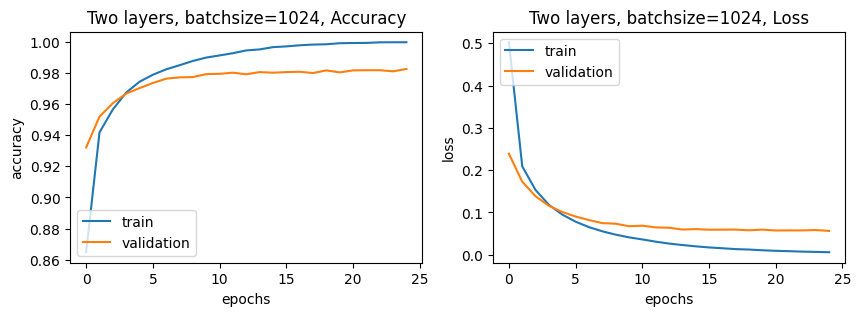

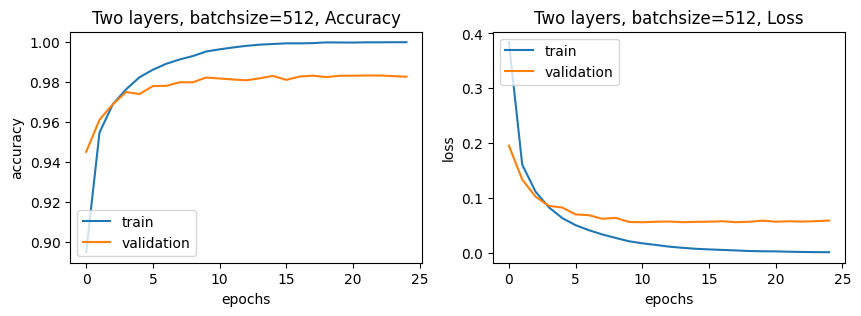

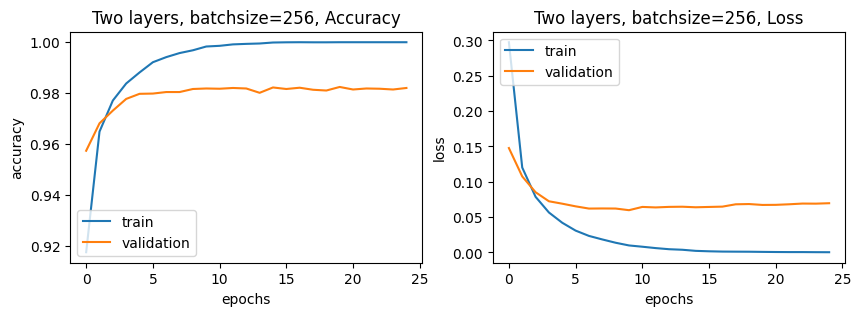

In [22]:
plot_accuracy_and_loss(history_list[0], 'Two layers, batchsize=2048', 'two-layers-batch-2048')
plot_accuracy_and_loss(history_list[1], 'Two layers, batchsize=1024', 'two-layers-batch-1024')
plot_accuracy_and_loss(history_list[2], 'Two layers, batchsize=512', 'two-layers-batch-512')
plot_accuracy_and_loss(history_list[3], 'Two layers, batchsize=256', 'two-layers-batch-256')

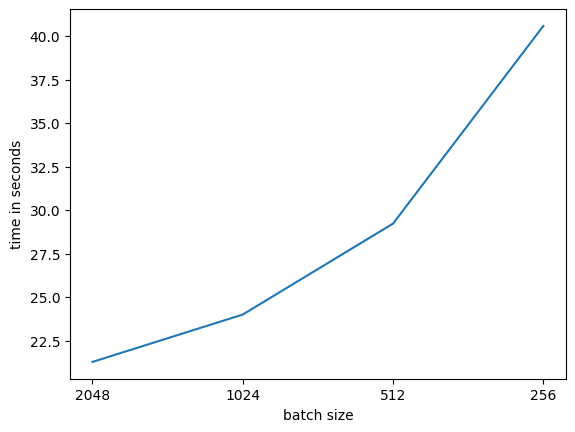

In [23]:
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('time in seconds')
plt.xticks(range(len(time_list)), batch_sizes)
file_helper.save_figure('batch-timing')
plt.show()

In [24]:
# A better size is 256, but that takes a LONG time to run!
comparison_batch_size = 1024

Epoch 1/25


/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 - 2s - 42ms/step - accuracy: 0.8860 - loss: 0.4092 - val_accuracy: 0.9531 - val_loss: 0.1613
Epoch 2/25
59/59 - 2s - 28ms/step - accuracy: 0.9602 - loss: 0.1369 - val_accuracy: 0.9656 - val_loss: 0.1112
Epoch 3/25
59/59 - 2s - 30ms/step - accuracy: 0.9762 - loss: 0.0817 - val_accuracy: 0.9735 - val_loss: 0.0826
Epoch 4/25
59/59 - 2s - 28ms/step - accuracy: 0.9840 - loss: 0.0554 - val_accuracy: 0.9782 - val_loss: 0.0739
Epoch 5/25
59/59 - 2s - 30ms/step - accuracy: 0.9886 - loss: 0.0392 - val_accuracy: 0.9793 - val_loss: 0.0694
Epoch 6/25
59/59 - 2s - 42ms/step - accuracy: 0.9912 - loss: 0.0309 - val_accuracy: 0.9788 - val_loss: 0.0698
Epoch 7/25
59/59 - 3s - 43ms/step - accuracy: 0.9942 - loss: 0.0215 - val_accuracy: 0.9817 - val_loss: 0.0608
Epoch 8/25
59/59 - 3s - 45ms/step - accuracy: 0.9953 - loss: 0.0175 - val_accuracy: 0.9829 - val_loss: 0.0575
Epoch 9/25
59/59 - 2s - 28ms/step - accuracy: 0.9972 - loss: 0.0119 - val_accuracy: 0.9804 - val_loss: 0.0641
Epoch 10/25
59/59 - 3

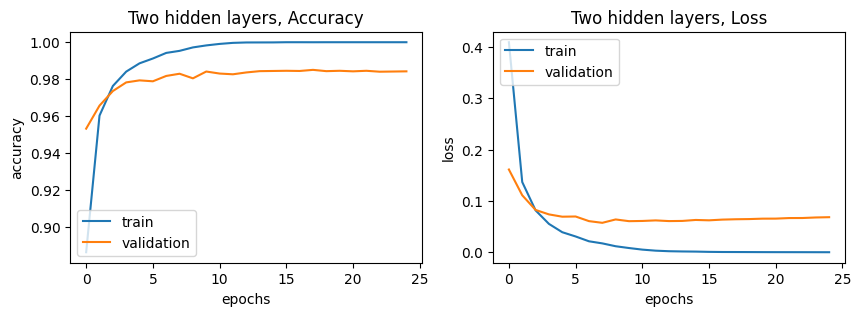

In [25]:
model = make_two_hidden_layers_model()
history_2HLM = run_and_report(model, 'Two hidden layers', 'two-hidden-layers', 
                              batch_size=comparison_batch_size, verbosity=2)

Epoch 1/25
59/59 - 1s - 15ms/step - accuracy: 0.7526 - loss: 0.9709 - val_accuracy: 0.8913 - val_loss: 0.4227
Epoch 2/25
59/59 - 0s - 4ms/step - accuracy: 0.9002 - loss: 0.3682 - val_accuracy: 0.9162 - val_loss: 0.3079
Epoch 3/25
59/59 - 0s - 4ms/step - accuracy: 0.9195 - loss: 0.2946 - val_accuracy: 0.9249 - val_loss: 0.2667
Epoch 4/25
59/59 - 0s - 4ms/step - accuracy: 0.9290 - loss: 0.2584 - val_accuracy: 0.9322 - val_loss: 0.2396
Epoch 5/25
59/59 - 0s - 4ms/step - accuracy: 0.9350 - loss: 0.2329 - val_accuracy: 0.9369 - val_loss: 0.2206
Epoch 6/25
59/59 - 0s - 4ms/step - accuracy: 0.9410 - loss: 0.2127 - val_accuracy: 0.9414 - val_loss: 0.2045
Epoch 7/25
59/59 - 0s - 4ms/step - accuracy: 0.9455 - loss: 0.1959 - val_accuracy: 0.9452 - val_loss: 0.1916
Epoch 8/25
59/59 - 0s - 4ms/step - accuracy: 0.9498 - loss: 0.1819 - val_accuracy: 0.9474 - val_loss: 0.1820
Epoch 9/25
59/59 - 0s - 4ms/step - accuracy: 0.9529 - loss: 0.1699 - val_accuracy: 0.9513 - val_loss: 0.1701
Epoch 10/25
59/59 

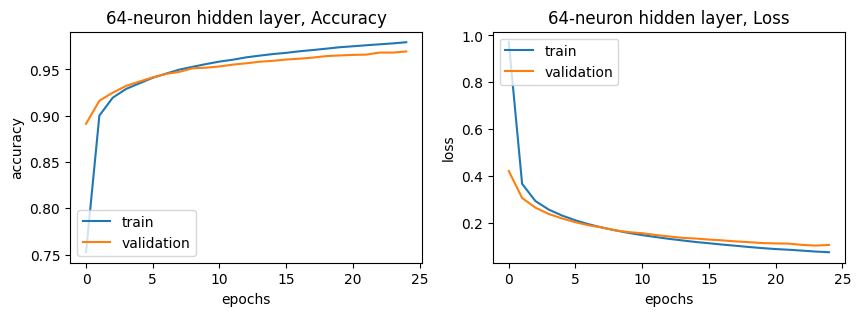

In [26]:
model = make_hidden_layer_n_neurons(64)
history_fc_64 = run_and_report(model, '64-neuron hidden layer', '64-neuron-hidden-layer', 
                               batch_size=comparison_batch_size, verbosity=2)

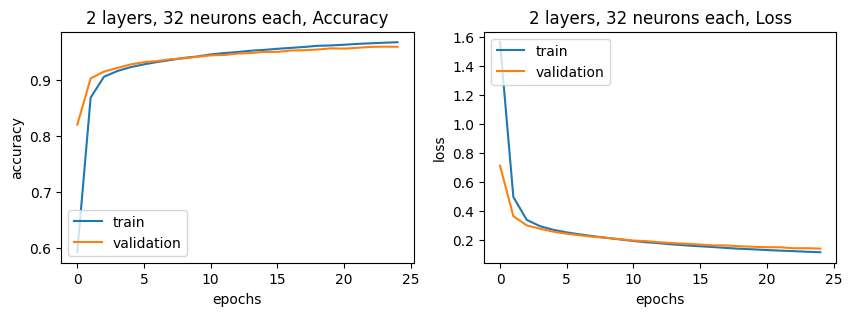

In [31]:
model = make_layers_model([32, 32], [False, False])
history_32_32 = run_and_report(model, '2 layers, 32 neurons each', '32-32-layers', 
                               batch_size=comparison_batch_size, verbosity=0)

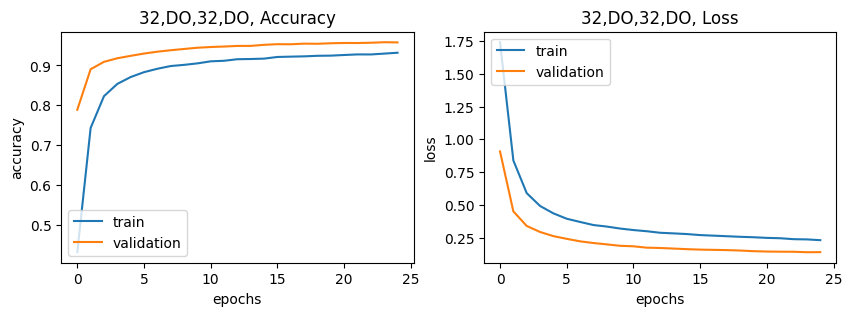

In [35]:
model = make_layers_model([32, 32], [True, True])
history_32_DO_32_DO = run_and_report(model, '32,DO,32,DO', '32-DO-32-DO', 
                               batch_size=comparison_batch_size, verbosity=0)

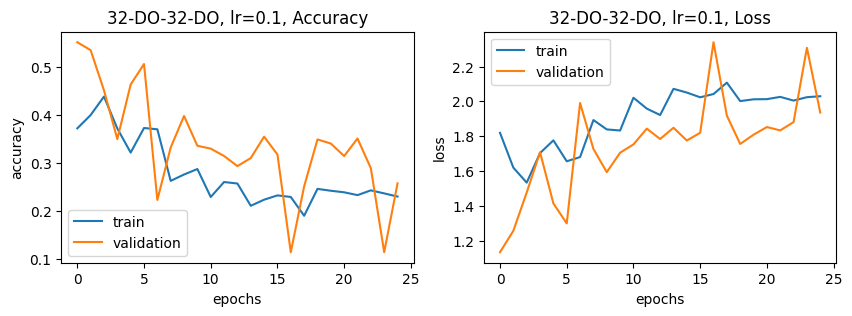

In [36]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.1)
history_32_DO_32_DO_LR_p1 = run_and_report(model, '32-DO-32-DO, lr=0.1', '32-DO-32-DO-LR-p1', 
                               batch_size=comparison_batch_size, verbosity=0)

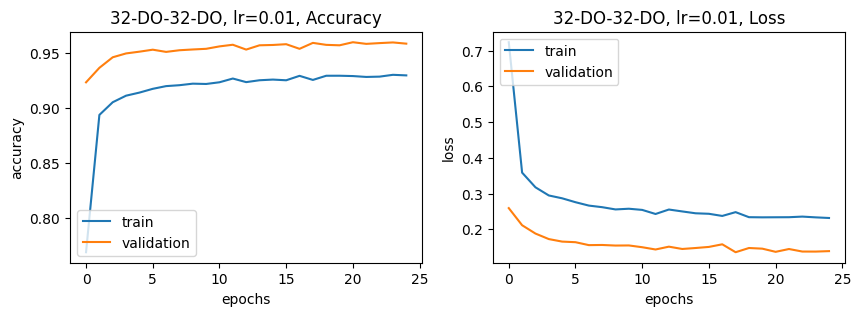

In [37]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.01)
history_32_DO_32_DO_LR_p01 = run_and_report(model, '32-DO-32-DO, lr=0.01', '32-DO-32-DO-LR-p01', 
                               batch_size=comparison_batch_size, verbosity=0)